In [1]:
%matplotlib inline

import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output
from tqdm import tqdm
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
import pickle

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import ccaTools as cca
        from tools import corrTools as ct
        from tools import decodeTools as decode
        from tools import lstm

        
        from tools import lstm
        import params
        mouse_defs = params.mouse_defs
        monkey_defs = params.monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(nbPath)
    
    # %run "S1-mouse-M1-decoding.ipynb"
    
    print('Done!')

FIGPATH = params.figPath / 'figS6-mouse-additional'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done!


### Get data

In [2]:
defs = mouse_defs

warnings.filterwarnings("ignore")
# mice
## 4 conditions
# allDFs_M1_pull_mouse, allDFs_Str_pull_mouse = dt.get_full_mouse_data(prep_pull = True)

## 2 conditions
allDFs_M1_mouse, allDFs_Str_mouse = dt.get_full_mouse_data(prep_pull = False)

# monkeys
# full_list_MCx_monkey, allDFs_MCx_monkey = dt.get_full_monkey_data(GoodDataList_CO)

warnings.filterwarnings("default")

# Classifying reach direction

In [3]:
from sklearn.naive_bayes import GaussianNB

def mouse_target_decoding(allDFs, epoch, area):
    defs = mouse_defs
    classifier_model = GaussianNB

    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        animal1 = df1.mouse[0]
        # within animal decoding ######
        AllData = dt.get_data_array([df1], epoch, area=area, model=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData1 = AllData[0,...]
        _,n_trial,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        # train the decoder
        _score=cross_val_score(classifier_model(),X1,AllTar,scoring='accuracy', cv=10).mean()
        within_score[df1.session[0]] = _score

        # across animal decoding ######
        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue

            AllData = dt.get_data_array([df1,df2], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData1 = AllData[0,...] 
            AllData2 = AllData[1,...]
            _,n_trial,n_time,n_comp = AllData1.shape

            # resizing
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))

            # aligned ###
            *_,U,V = cca.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_comp*n_time))
            V = V.reshape((-1,n_comp*n_time))
            AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
            trial_index = np.arange(len(AllTar))
            params.rng.shuffle(trial_index)
            X_train, Y_train = U[trial_index,:], AllTar[trial_index]
            params.rng.shuffle(trial_index)
            X_test, Y_test   = V[trial_index,:], AllTar[trial_index]

            # train the decoder
            classifier = classifier_model()
            classifier.fit(X_train, Y_train)
            # test the decoder
            _score = classifier.score(X_test,Y_test)
            aligned_score[df1.session[0]][df2.session[0]]=_score

            # unaligned ###
            X1 = X1.reshape((-1,n_comp*n_time))
            X2 = X2.reshape((-1,n_comp*n_time))
            AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
            trial_index = np.arange(len(AllTar))
            params.rng.shuffle(trial_index)
            X_train, Y_train = X1[trial_index,:], AllTar[trial_index]
            params.rng.shuffle(trial_index)
            X_test, Y_test   = X2[trial_index,:], AllTar[trial_index]
            # train the decoder
            classifier = classifier_model()
            classifier.fit(X_train, Y_train)
            # test the decoder
            _score = classifier.score(X_test,Y_test)
            unaligned_score[df1.session[0]][df2.session[0]]=_score

    return within_score, aligned_score, unaligned_score


In [4]:
within_score, aligned_score, unaligned_score = mouse_target_decoding(allDFs_M1_mouse, defs.prep_epoch, defs.areas[0])

  0%|          | 0/6 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [6]:
len(allDFs_M1_mouse)

6

### Fig S6A: CCA for mouse for four conditions


/home/jcc319/multi_animal_alignment/tools/ccaTools.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))


Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.000244140625)
Executed: `plot_cca` in 13.3s


/home/jcc319/anaconda3/envs/cca2/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


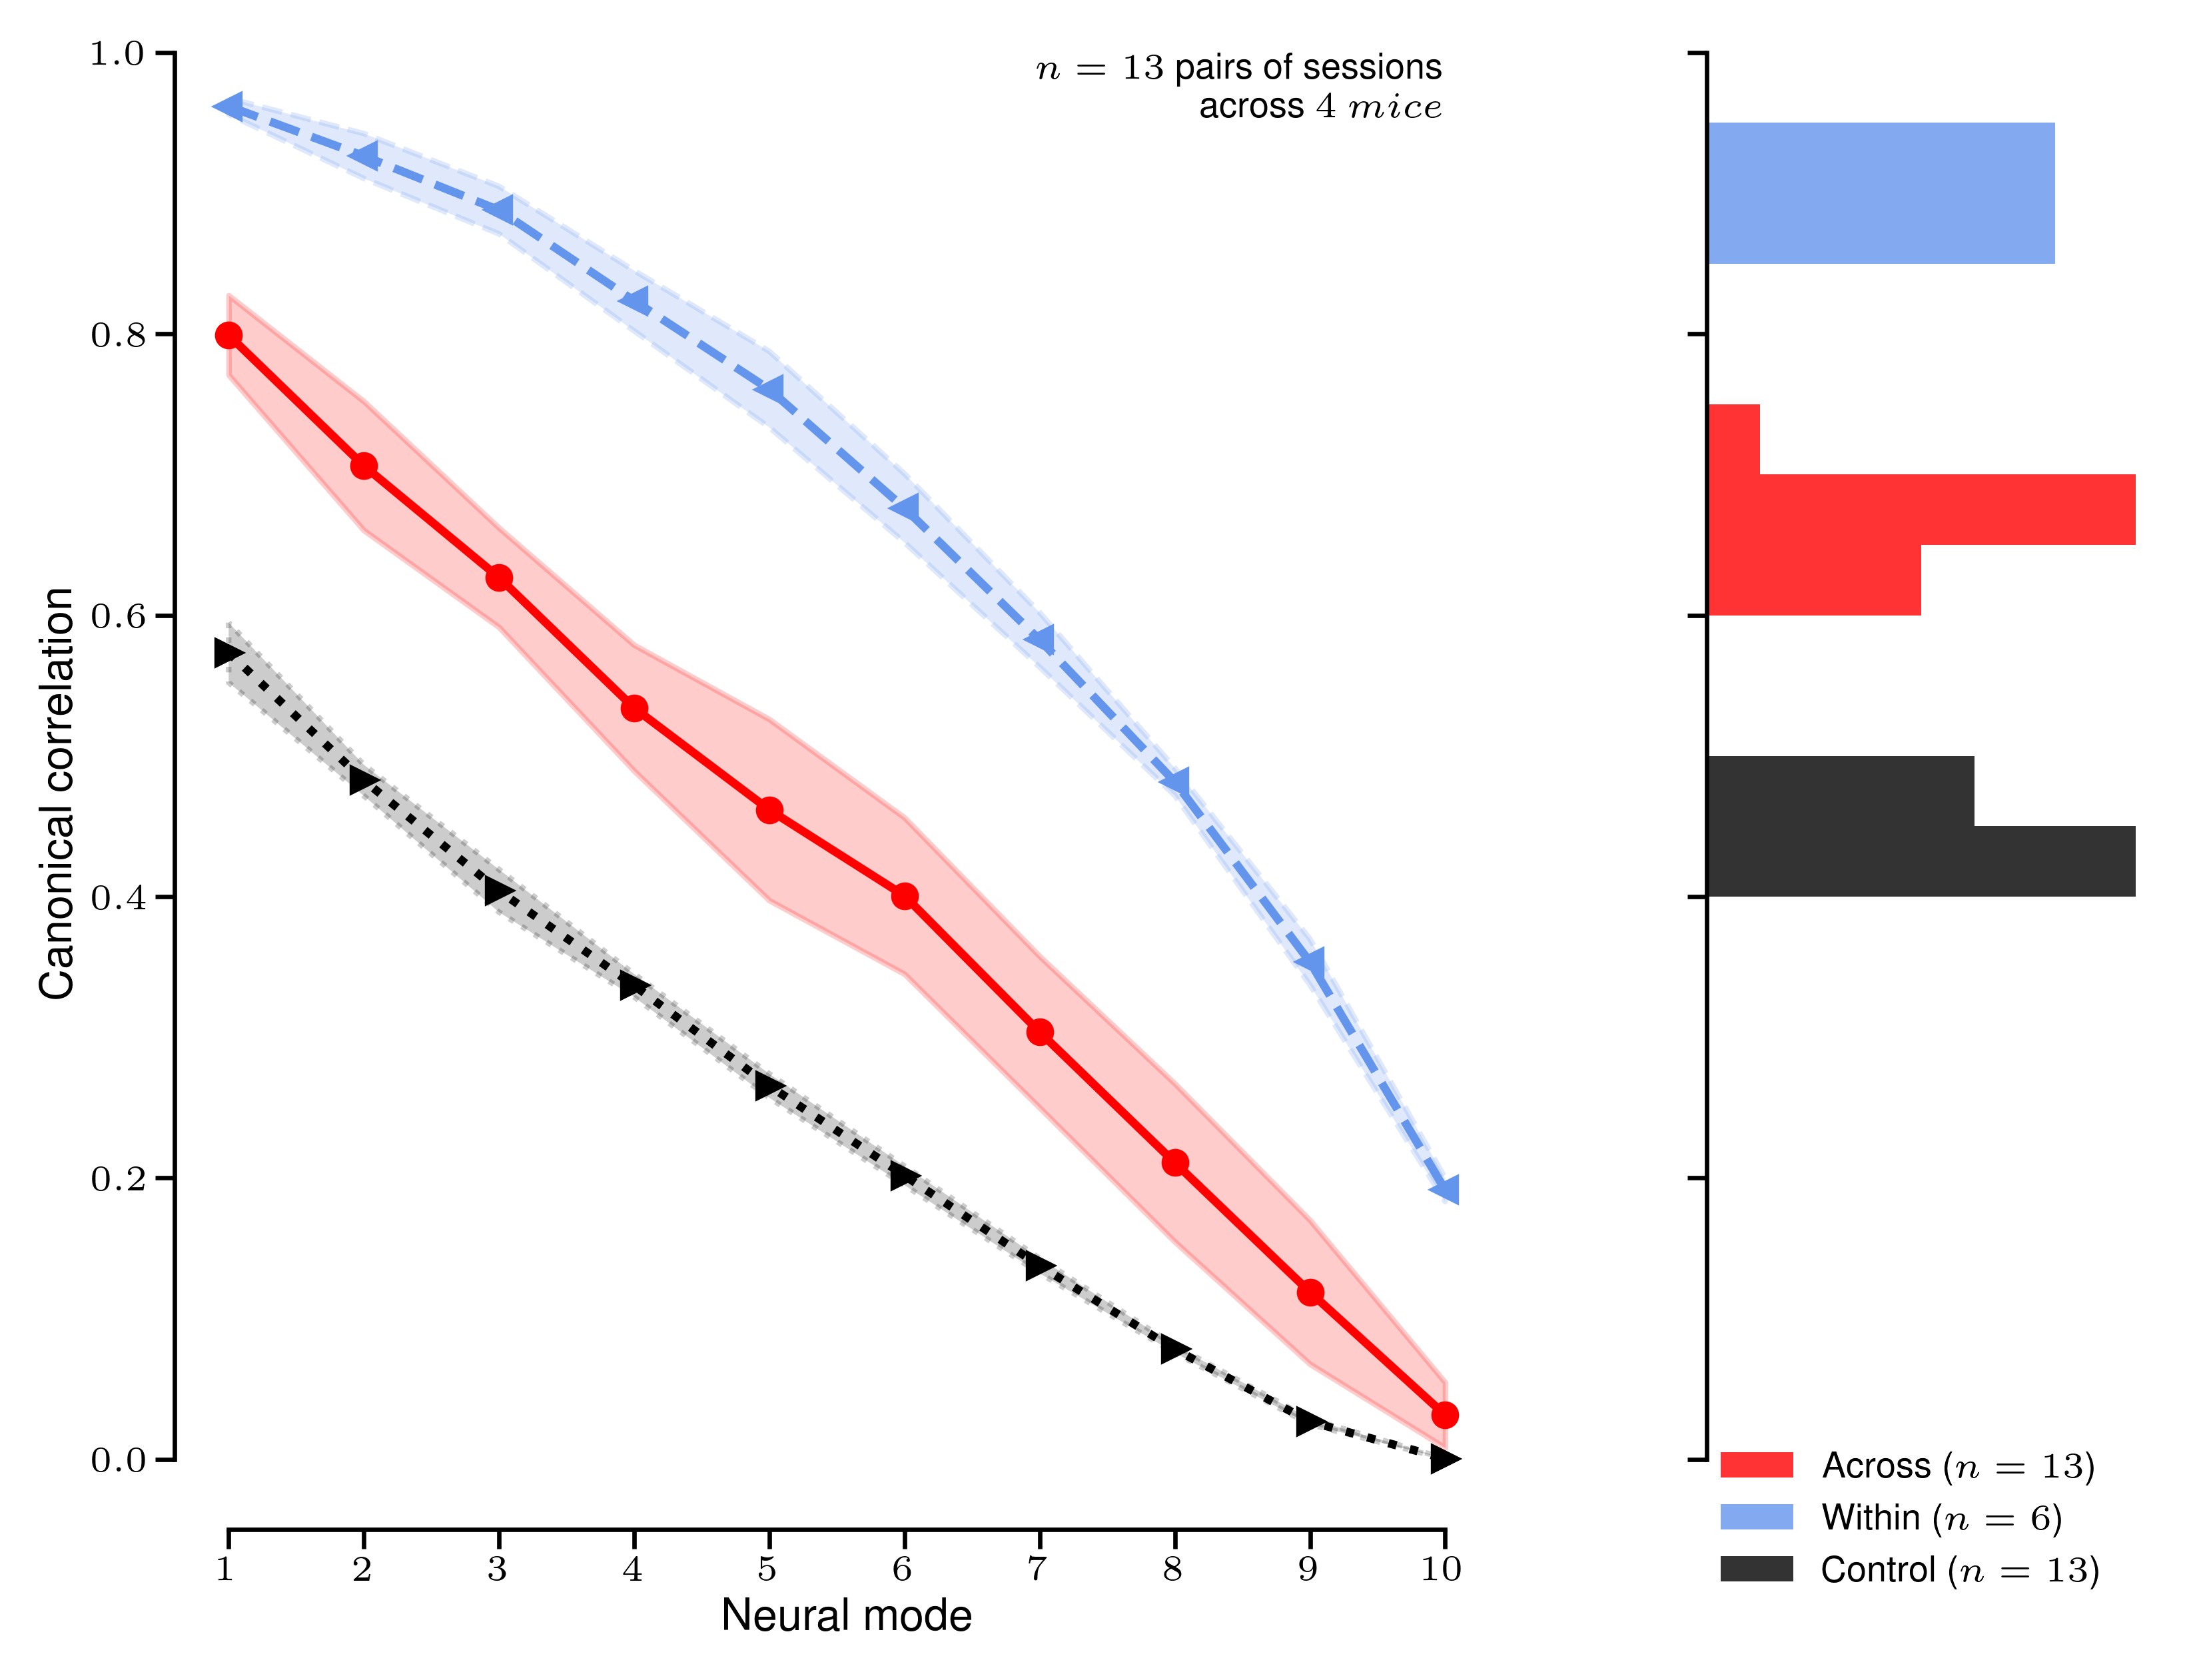

In [3]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw={'width_ratios': [params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]]})

# cca.plot_cca(axes[0], axes[1], allDFs_M1_mouse, 
#             mouse_defs.exec_epoch, 
#             mouse_defs.areas[0], 
#             mouse_defs.n_components, 
#             dataset='mouse')

cca.plot_cca(axes[0], axes[1], allDFs_M1_pull_mouse, 
            mouse_defs.exec_epoch_pull, 
            mouse_defs.areas[0], 
            mouse_defs.n_components, 
            dataset='mouse')
fig.savefig(FIGPATH / 'mouse-cca-pull-4targets.pdf', format='pdf', bbox_inches='tight')


### Fig S8B: Decoding for mouse MCx

100%|█████████████████████████████████████████████| 6/6 [09:11<00:00, 91.93s/it]


Executed: `mouse_decoding` in 551.6s
Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=3.0, pvalue=0.001220703125)


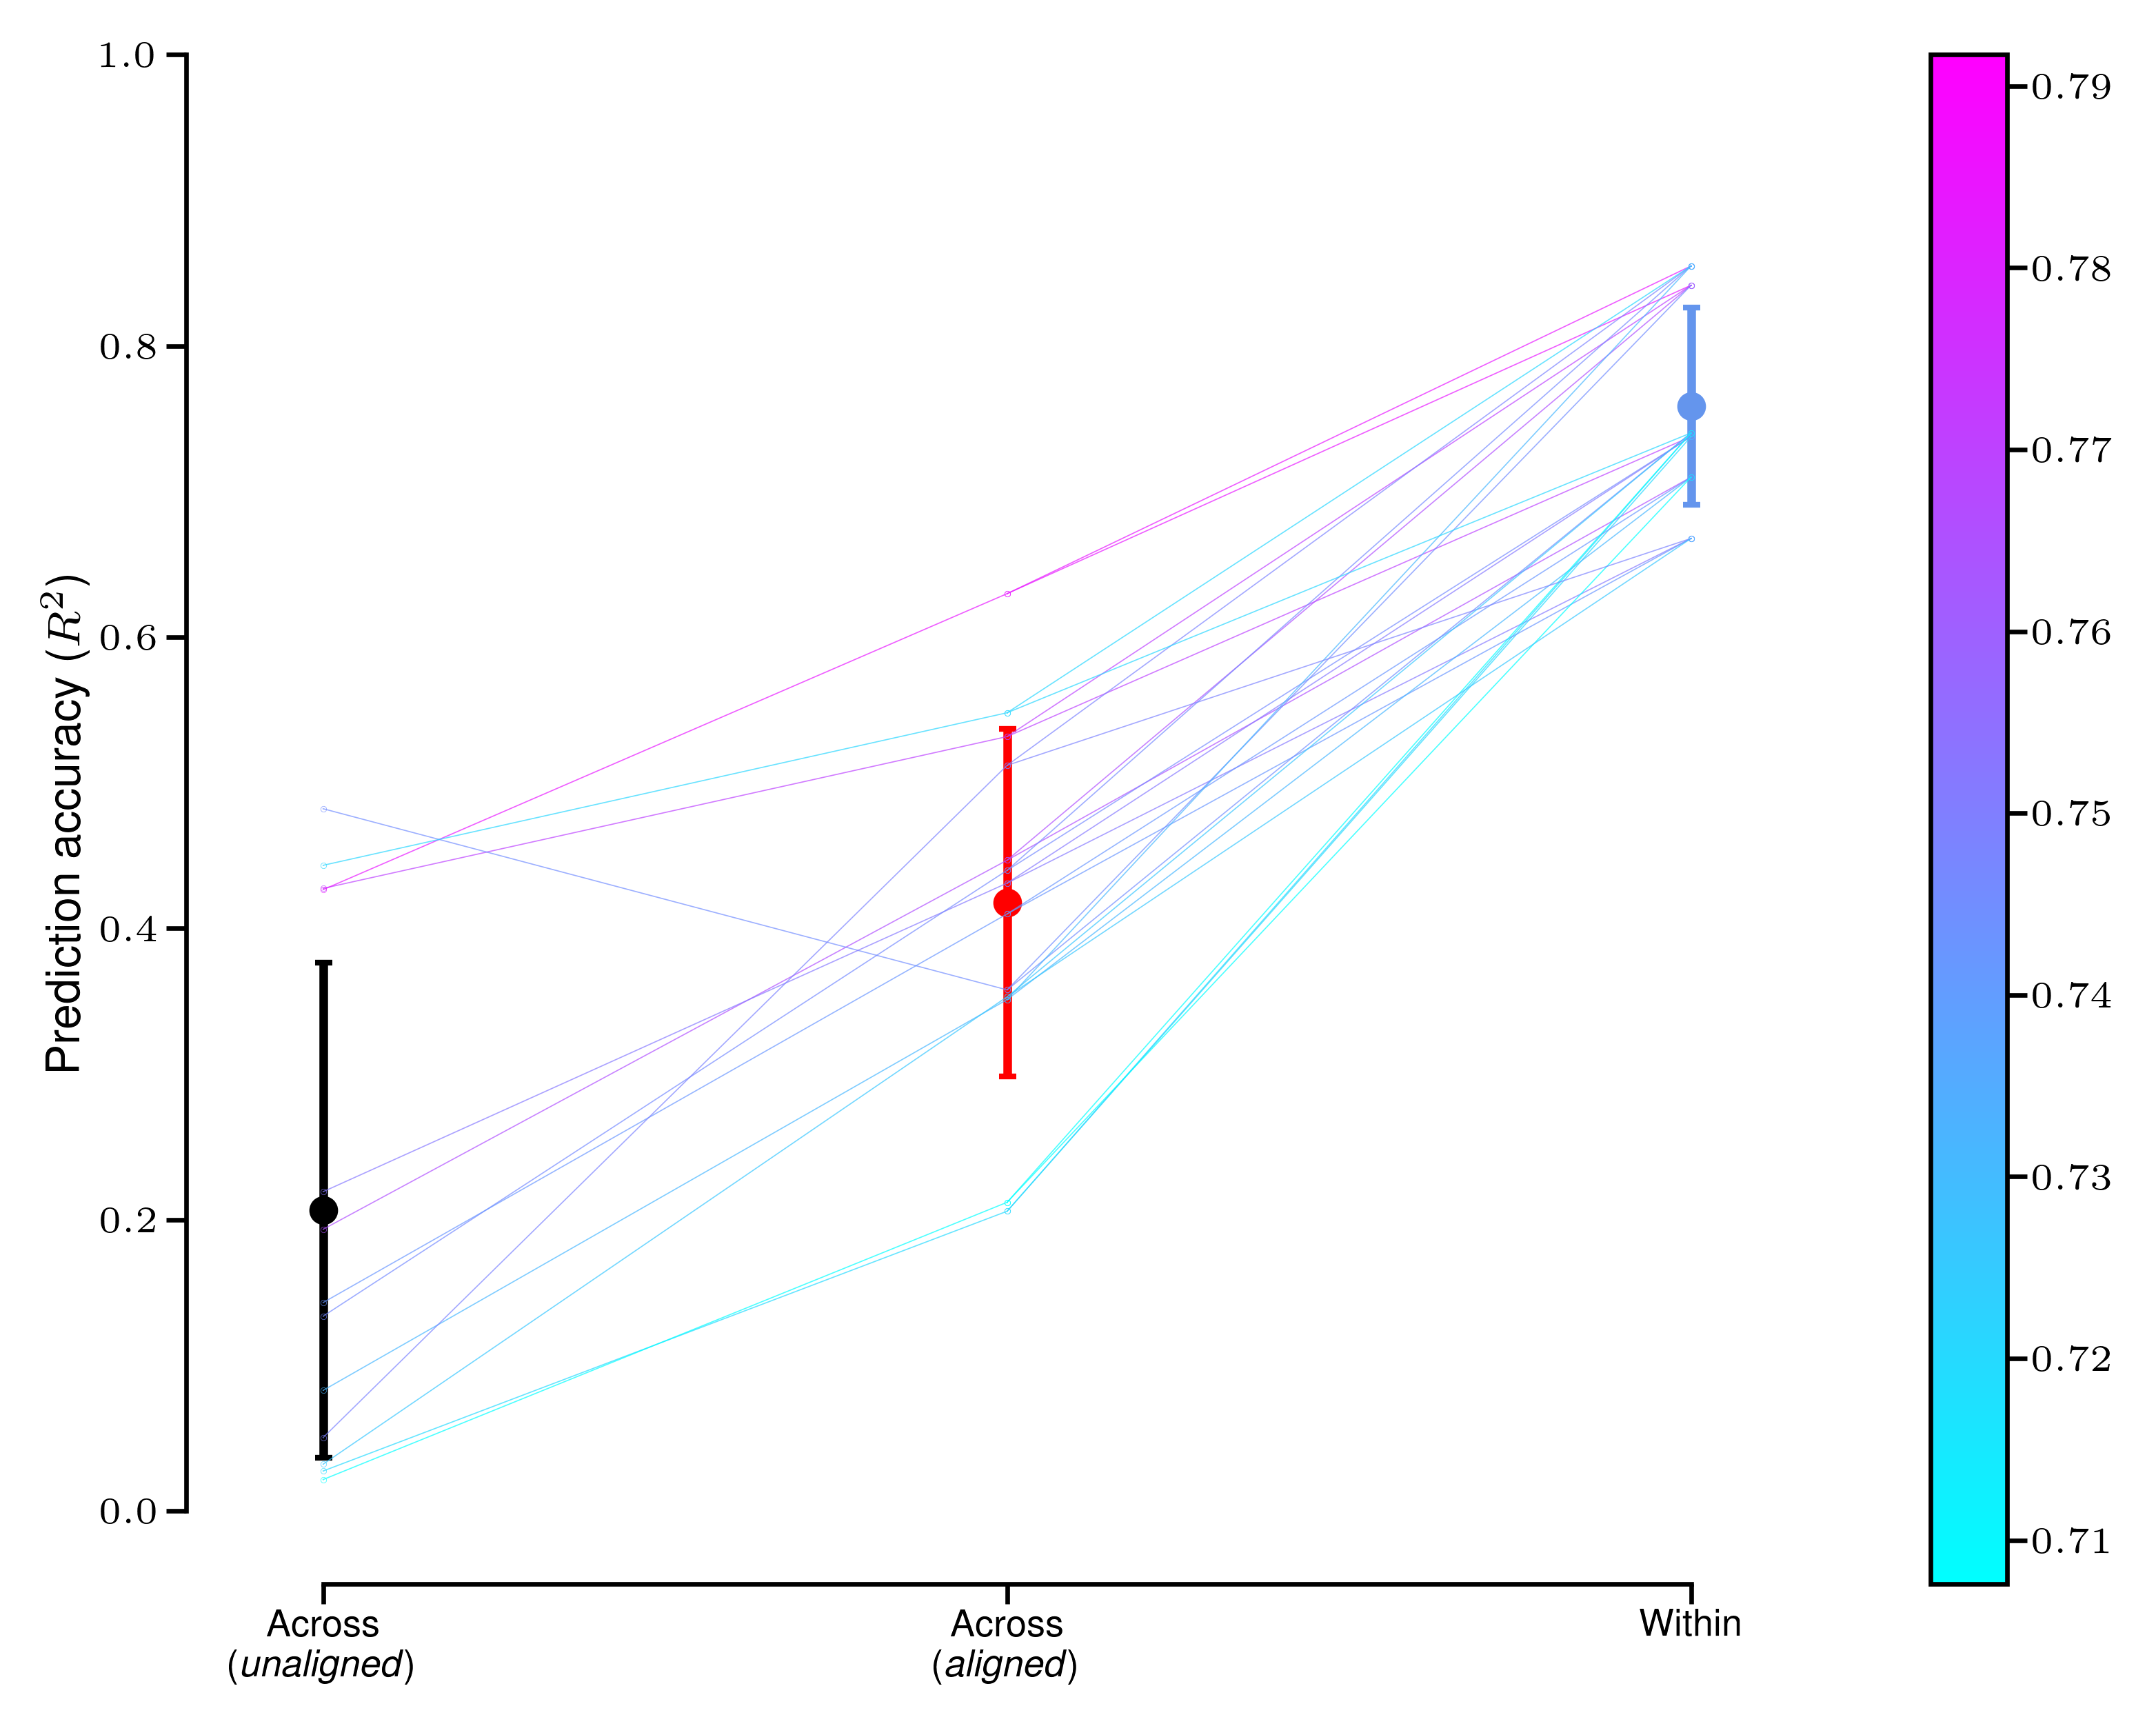

In [4]:
warnings.simplefilter("ignore")
fig, ax = plt.subplots()
decode.plot_decoding(ax, allDFs_Str_mouse, 
                 epoch = mouse_defs.exec_epoch_decode, 
                 area = mouse_defs.areas[0], 
                 dataset = 'mouse', 
                 color_by_behav_corr = True)

fig.savefig(FIGPATH / 'mouse-decoding-M1.pdf', format='pdf', bbox_inches='tight')
warnings.simplefilter("default")


### Fig S8C&D: CCA for mouse MCx vs Str

#### Get data

In [5]:
pairFileList_M1_mouse = dt.get_paired_files_mouse(allDFs_M1_mouse)
pairFileList_Str_mouse = dt.get_paired_files_mouse(allDFs_Str_mouse)

side1df_M1 = [allDFs_M1_mouse[i] for i,_ in pairFileList_M1_mouse]
side2df_M1 = [allDFs_M1_mouse[j] for _,j in pairFileList_M1_mouse]

side1df_Str = [allDFs_Str_mouse[i] for i,_ in pairFileList_Str_mouse]
side2df_Str = [allDFs_Str_mouse[j] for _,j in pairFileList_Str_mouse]

#### Fig S8C: CCA across modes

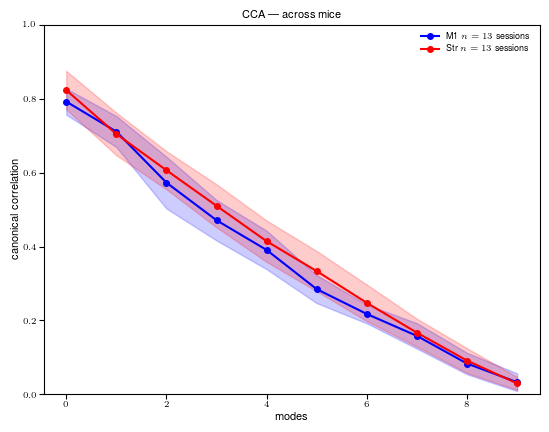

In [6]:
defs = mouse_defs

ccs_M1 = cca.get_ccs(side1df_M1, side2df_M1, 
                mouse_defs.exec_epoch, 
                mouse_defs.areas[0], 
                mouse_defs.n_components)

ccs_Str = cca.get_ccs(side1df_Str, side2df_Str,
                mouse_defs.exec_epoch,
                mouse_defs.areas[1],
                mouse_defs.n_components)

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, ccs_M1, color='b', marker = 'o', label=f'{defs.areas[0]} $n={ccs_M1.shape[1]}$ sessions')
utility.shaded_errorbar(ax, ccs_Str, color='r', marker = 'o', label=f'{defs.areas[1]} $n={ccs_Str.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('modes')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across mice', usetex=True);

plt.savefig(FIGPATH / 'mouse-str-m1-cca-modes.pdf', format='pdf', bbox_inches='tight')


#### Fig S8D: Mean of top 4 CCs

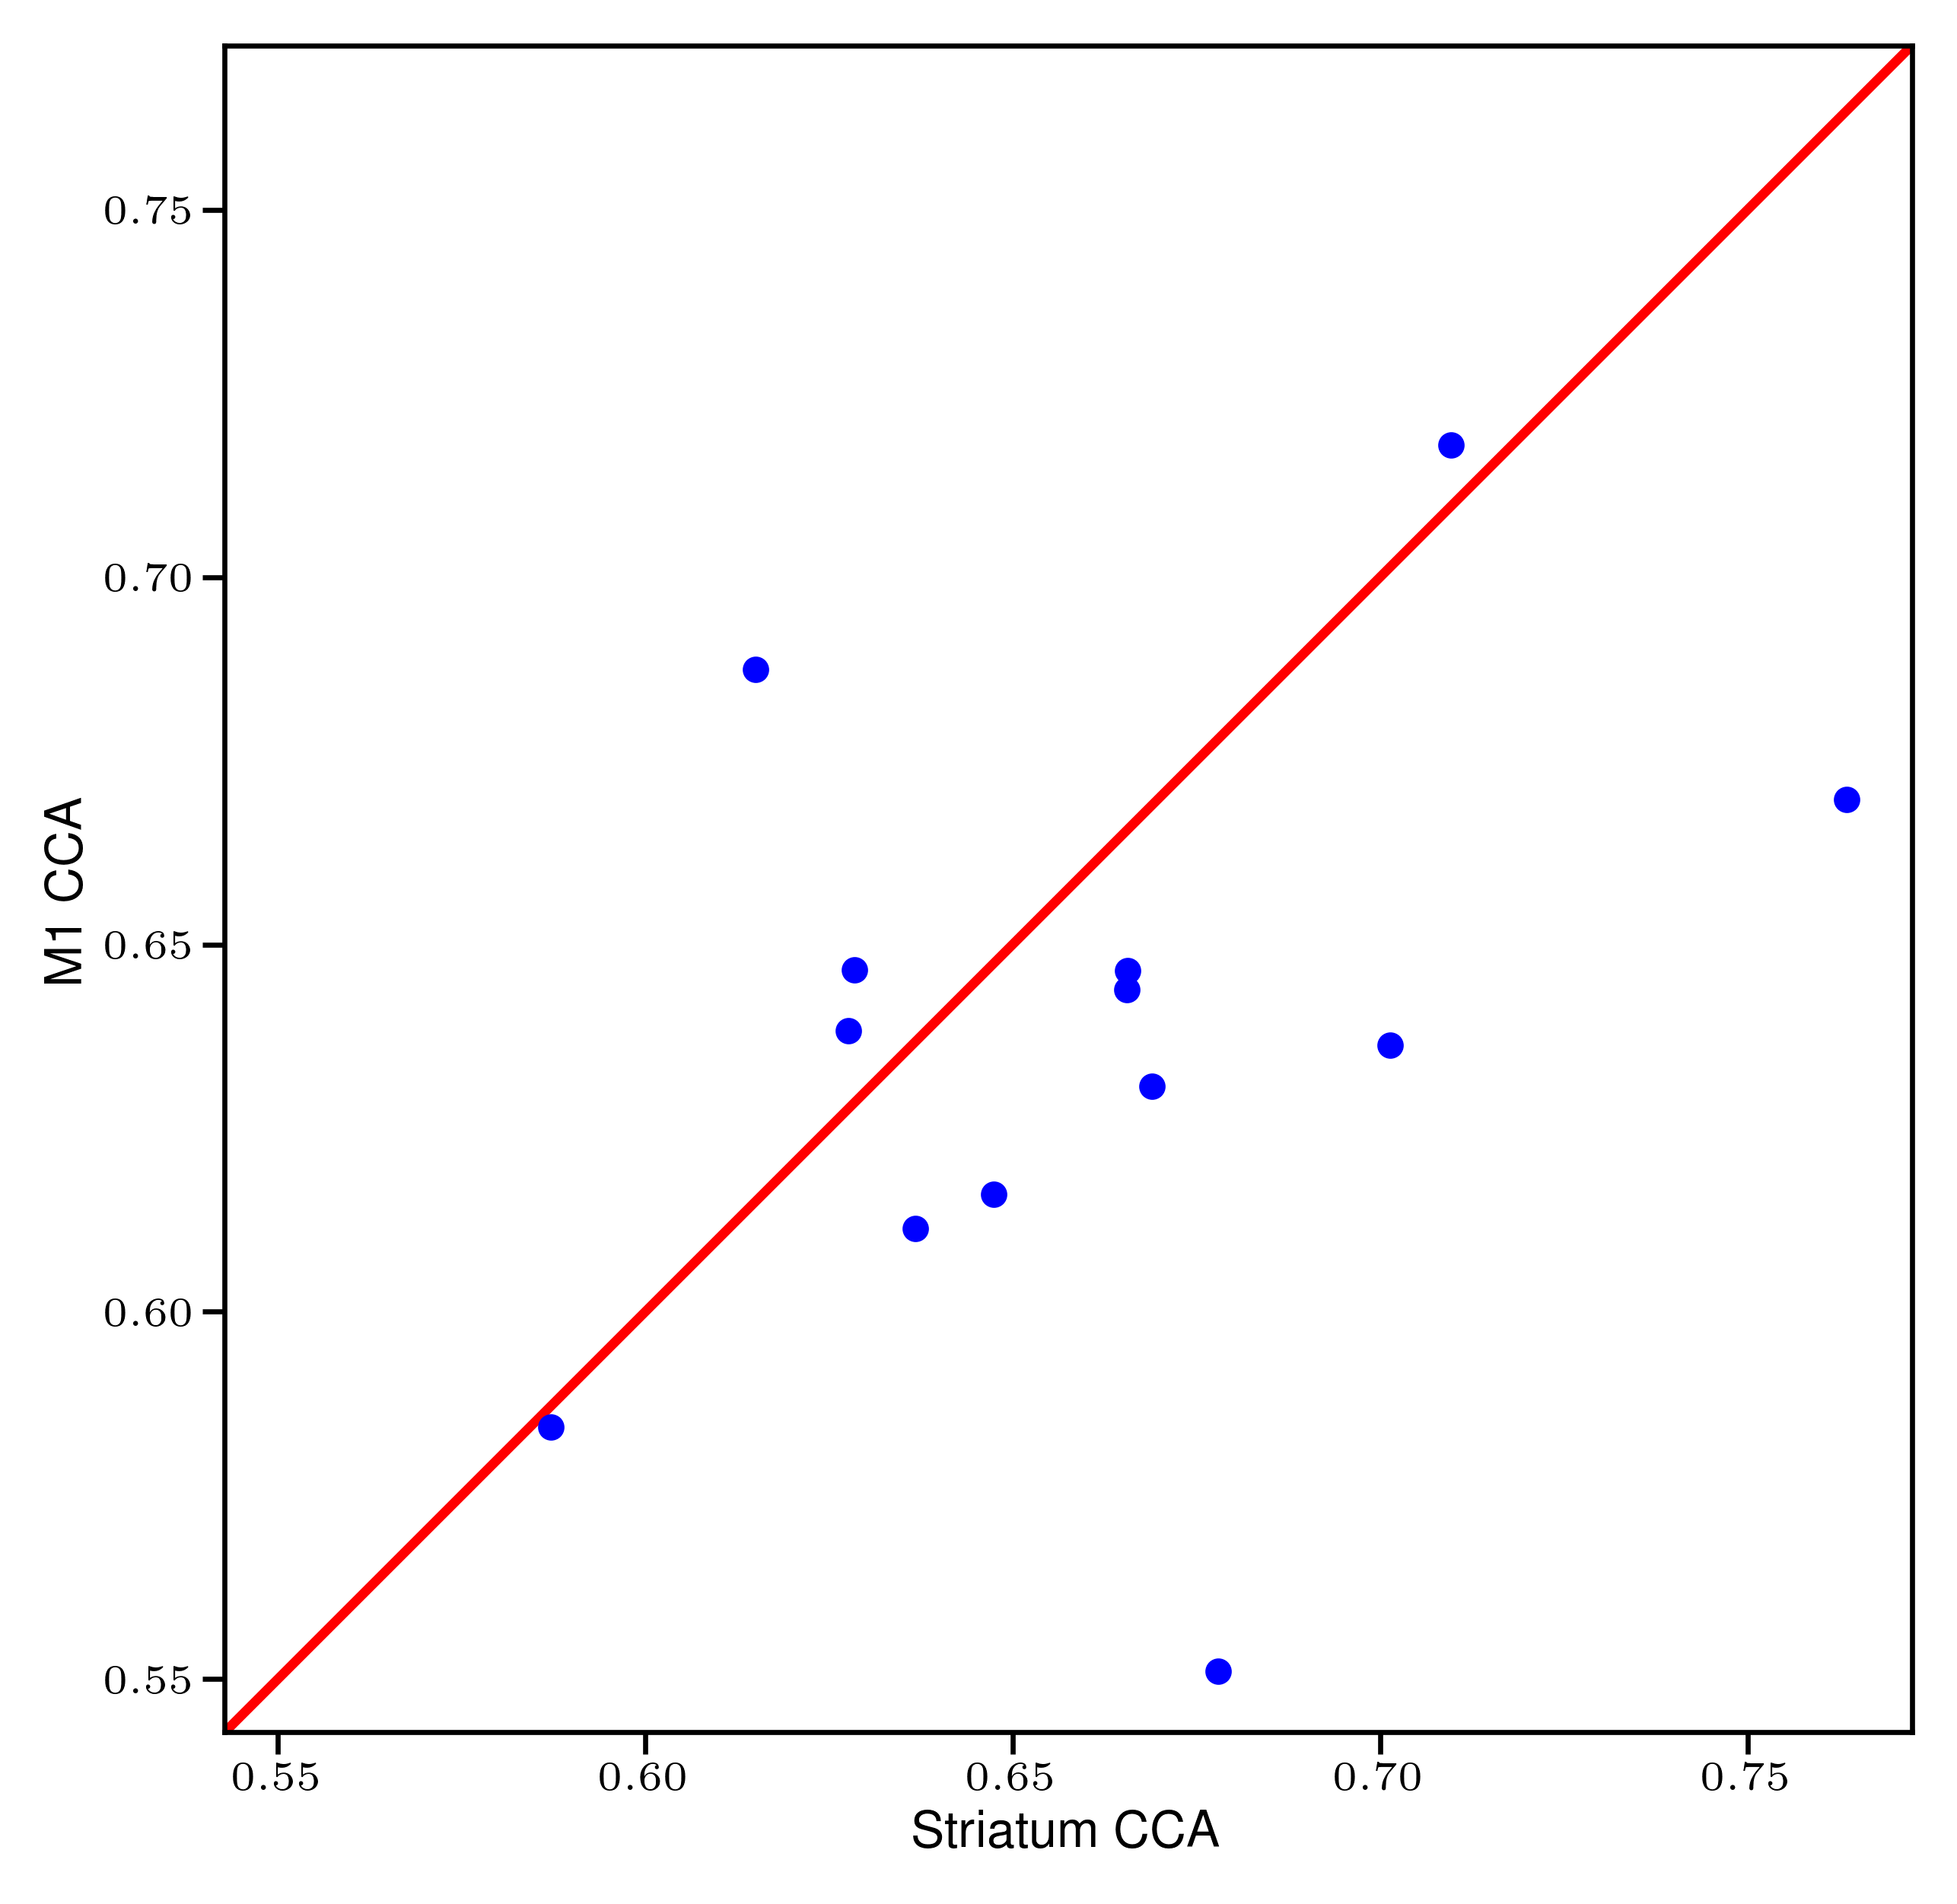

In [7]:
mean_ccs_M1 = np.mean(ccs_M1[:4], axis = 0)
mean_ccs_Str = np.mean(ccs_Str[:4], axis = 0)

fig, ax = plt.subplots()
ax.scatter(mean_ccs_Str, mean_ccs_M1, marker = 'o', color = 'b', s = 10)
ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes, zorder=-1)

ax.set_aspect(1)
xmin, xmax, ymin, ymax = ax.axis()
ax.axis([min(xmin,ymin), max(xmax,ymax), min(xmin,ymin), max(xmax,ymax)])
ax.set_xlabel('Striatum CCA')
ax.set_ylabel('M1 CCA')

fig.savefig(FIGPATH / 'mouse-str-m1-cca-mean.pdf', format='pdf', bbox_inches='tight')

### Fig S8E: Decoding for mouse MCx vs Str

In [8]:
def plot_mouse_aligned_decoding(AllDFs, area_code=1):
    defs = mouse_defs
    aligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        aligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            AllData, AllVel = dt.get_data_array_and_pos([df1, df2], defs.exec_epoch_decode, area=defs.areas[area_code], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))

            *_,U,V = cca.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

    return aligned_score

100%|█████████████████████████████████████████████| 6/6 [01:08<00:00, 11.34s/it]


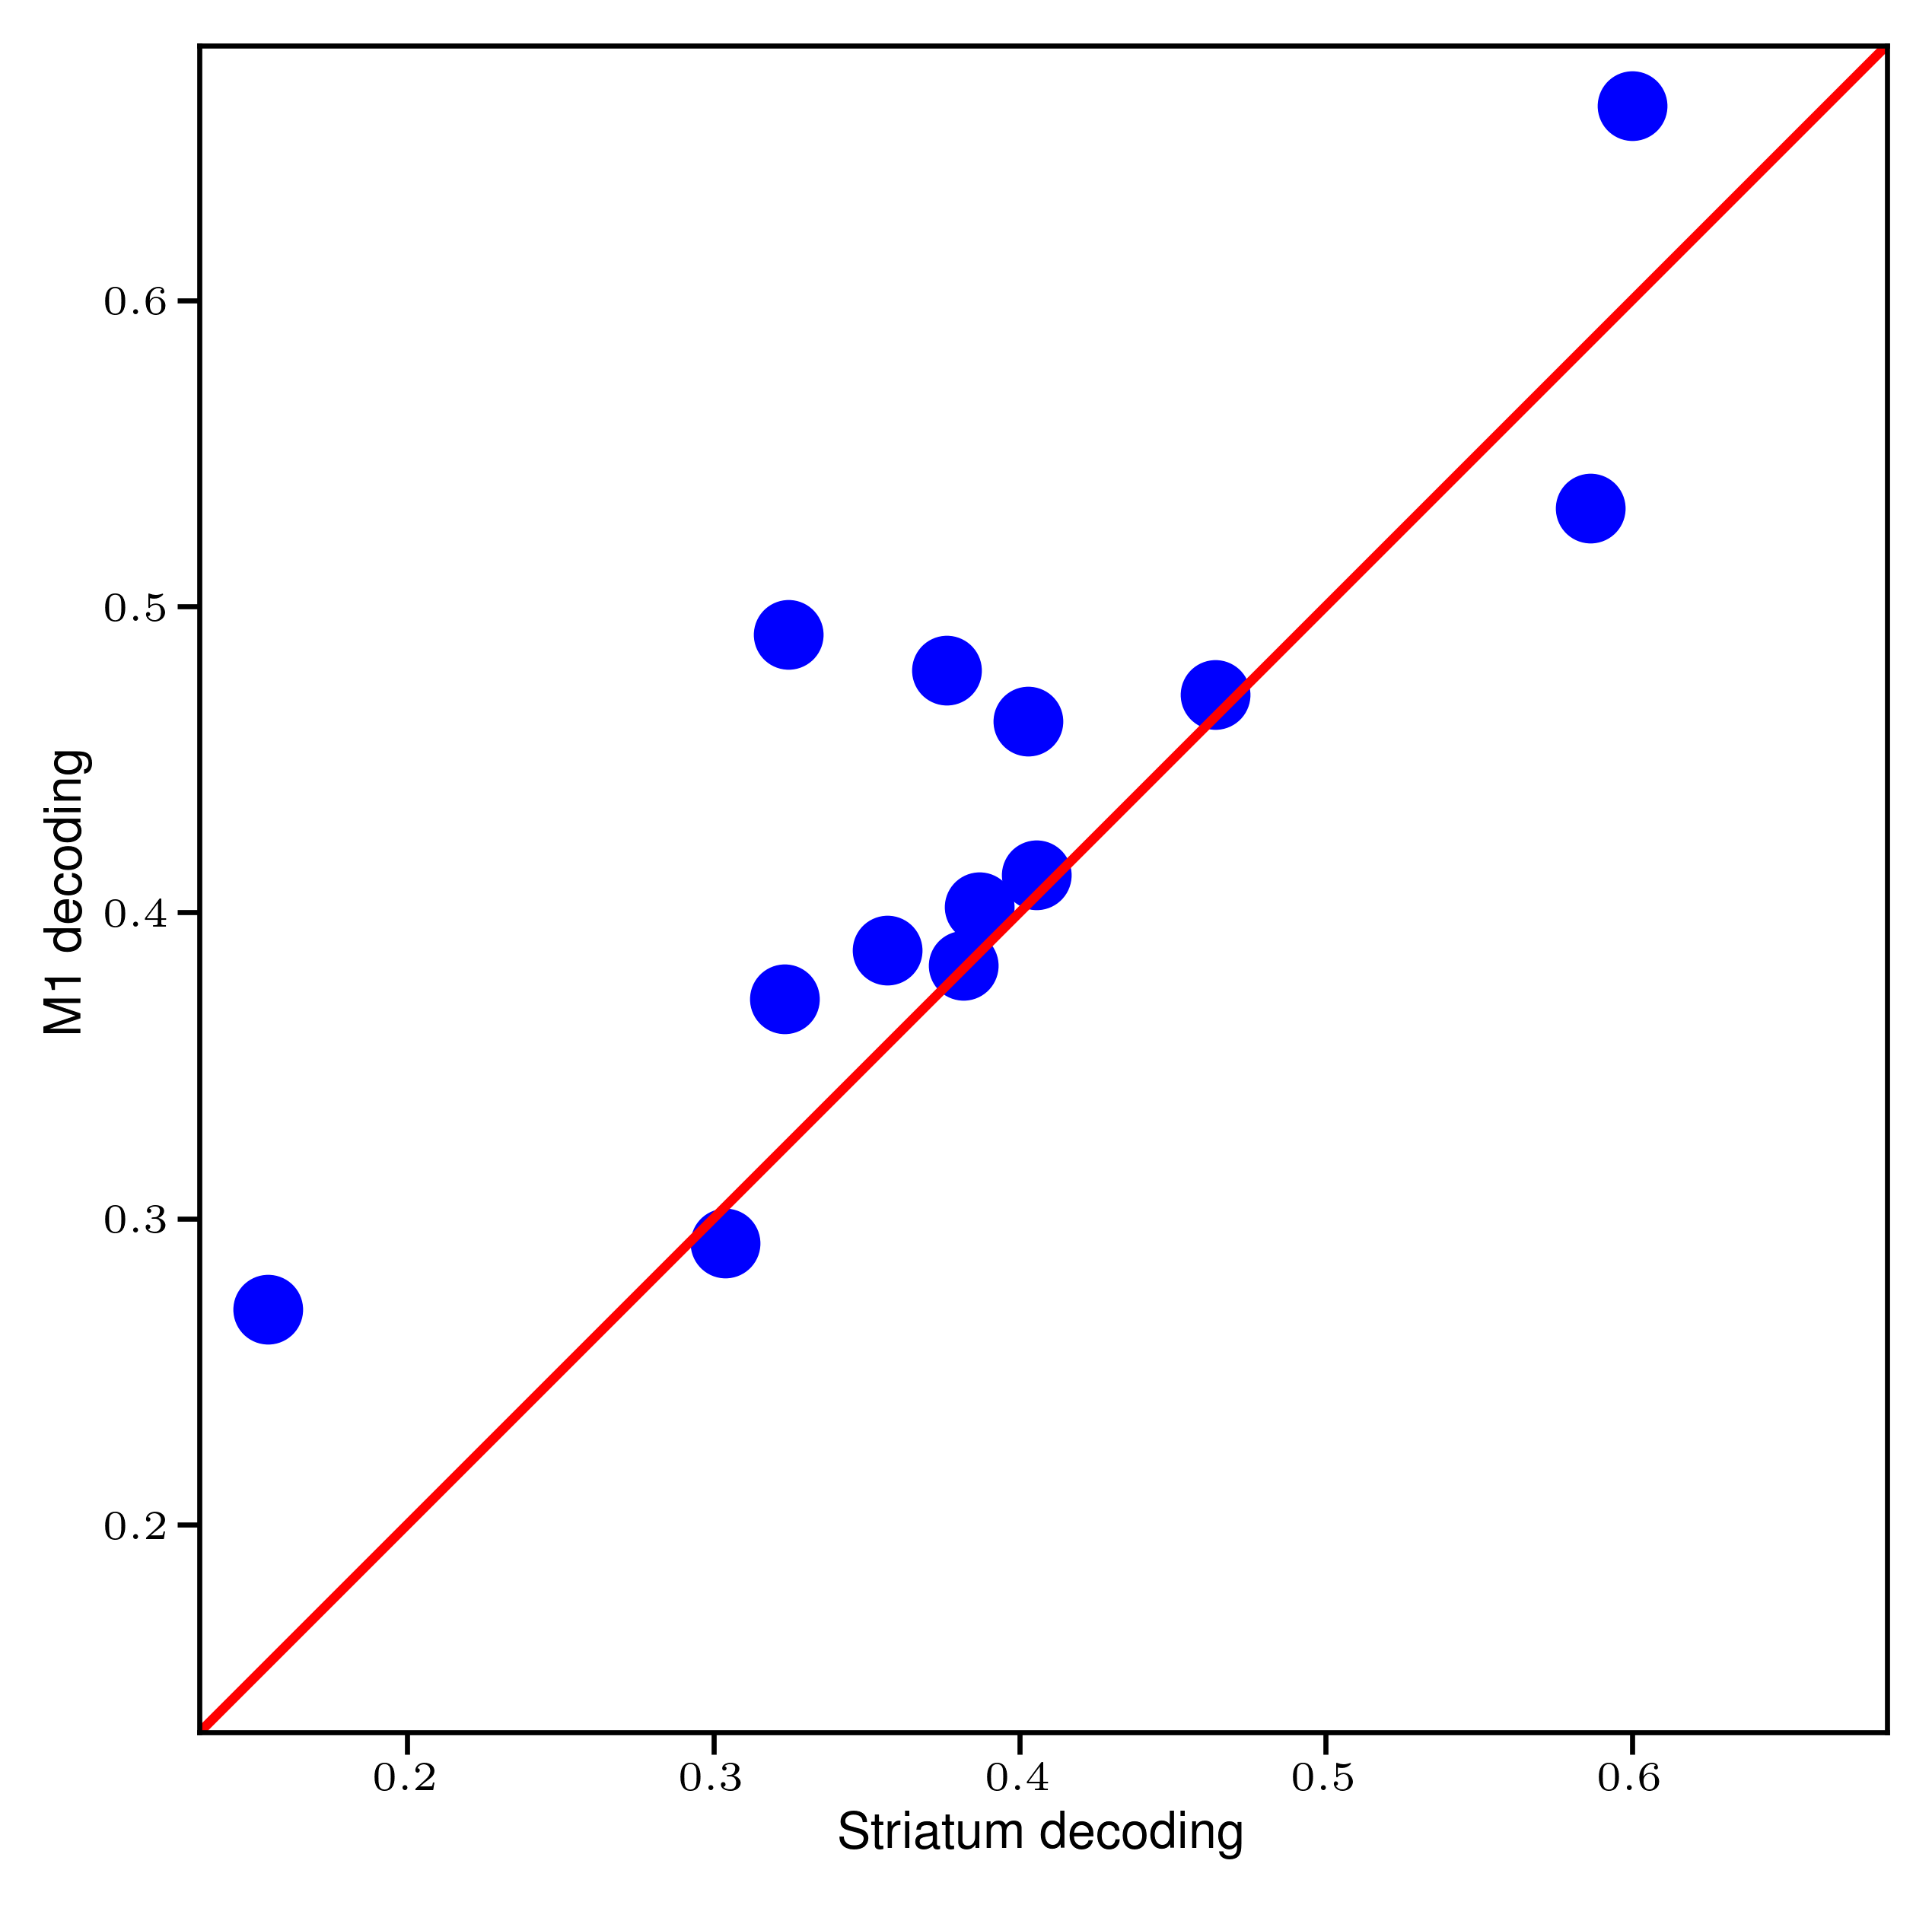

In [9]:
str_align = plot_mouse_aligned_decoding(allDFs_Str_mouse, area_code=1)
m1_align = plot_mouse_aligned_decoding(allDFs_M1_mouse, area_code=0)

fig, ax = plt.subplots()

for key1,val in m1_align.items():
    for key2 in val:
        ax.plot(str_align[key1][key2], m1_align[key1][key2], 
                marker = 'o', color = 'b', ms = 10)
ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes)

ax.set_aspect(1)
xmin, xmax, ymin, ymax = ax.axis()
ax.set_xlim([min(xmin, ymin), max(xmax, ymax)])
ax.set_ylim([min(xmin, ymin), max(xmax, ymax)])
ax.set_xlabel('Striatum decoding')
ax.set_ylabel('M1 decoding')

fig.savefig(FIGPATH / 'mouse-str-m1-decoding.pdf', format='pdf', bbox_inches='tight')

### FigS6F: Behavioral correlation vs decoding

In [10]:
@utility.report
def plot_monkey_decode_corr(ax, full_list, allDFs_MCx):
    defs = monkey_defs
        
    across_corrs_monkeys = ct.trim_across_monkey_corr(allDFs_MCx)

    pairIndex_across = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairIndex_across.append((I,J))
            
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        pathPickle = root / 'monkey-pickles' / f'{allDFs_MCx[id1].session[0]}-{allDFs_MCx[testId].session[0]}_{defs.n_components}_aligned.p'

        assert os.path.exists(pathPickle), 'Run figure 2 first to save the decoding data!'

        with open(pathPickle,"rb") as f:
            reg_scores_across.append(pickle.load(f))
    pop_score_across = np.array(reg_scores_across)
            
            
    corr_monkey=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = allDFs_MCx[id1] , allDFs_MCx[testId]
        behav = np.array(across_corrs_monkeys[df1.session[0]][df2.session[0]])
        behav = behav[behav>params.Behav_corr_TH]
        decode = pop_score_across[i]
        corr_monkey.append((decode , np.mean(behav)))
    corr_monkey = np.array(corr_monkey)   


    #plotting
    ax.scatter(corr_monkey[:,1],corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([.15,1])
    ax.spines['left'].set_bounds([.2,1])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    
@utility.report
def plot_mouse_decode_corr(ax, AllDFs):
    defs = mouse_defs
    across_corrs_mice = ct.trim_across_mouse_corr (AllDFs)
    
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    M1_scores = []
    for (id1, testId) in pairIndex_across:
        aligned_score, _ = decode.across_animal_decoding(AllDFs[id1], AllDFs[testId], defs, defs.exec_epoch_decode,area=defs.areas[0], n_components=defs.n_components)

        M1_scores.append(aligned_score)
    M1_score_across = np.array(M1_scores)


    Str_scores = []
    for (id1, testId) in pairIndex_across:
        aligned_score, _ = decode.across_animal_decoding(AllDFs[id1], AllDFs[testId], defs, defs.exec_epoch_decode,area=defs.areas[1], n_components=defs.n_components)

        Str_scores.append(aligned_score)
    Str_score_across = np.array(Str_scores)


    corr_mice=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = AllDFs[id1] , AllDFs[testId]
        behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        M1_decode = M1_score_across[i]
        Str_decode = Str_score_across[i]
        corr_mice.append((M1_decode , np.mean(behav), Str_decode))
    corr_mice = np.array(corr_mice)

    #plotting
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color=params.colors.MouseM1, label='Mice M1', zorder=1)
    ax.scatter(corr_mice[:,1],corr_mice[:,2],color=params.colors.MouseStr, label='Mice Str', zorder=1)

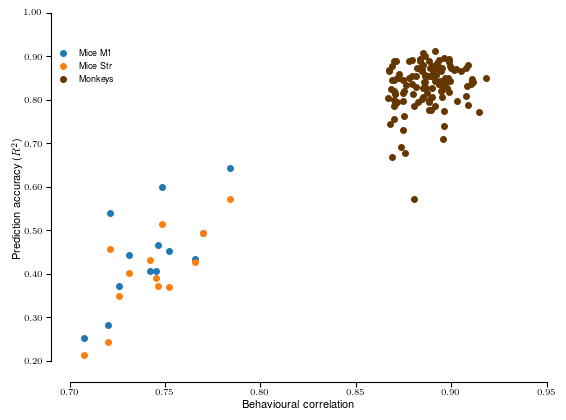

In [11]:
fig=plt.figure(dpi=100)
ax = fig.add_subplot()

plot_mouse_decode_corr(ax, allDFs_M1_mouse)
plot_monkey_decode_corr(ax, full_list_MCx_monkey, allDFs_MCx_monkey)

fig.savefig(FIGPATH / 'decode-behav-corr.pdf', format='pdf', bbox_inches='tight')
clear_output()